In [1]:
import chess.pgn
import re
import pandas as pd
import numpy as np
from collections import defaultdict

In [2]:
def parse_eval(comment):
    """Extrae la evaluación del motor desde un comentario PGN"""
    if not comment:
        return None
    match = re.search(r'\[%eval (-?\d+\.?\d*|\#-?\d+)', comment)
    if match:
        eval_str = match.group(1)
        if eval_str.startswith('#'):
            mate_in = int(eval_str[1:])
            return 100 if mate_in > 0 else -100
        else:
            return float(eval_str)
    return None

In [3]:
def parse_clock(comment):
    """Extrae el tiempo restante del reloj desde un comentario PGN"""
    if not comment:
        return None
    match = re.search(r'\[%clk (\d+):(\d+):(\d+(\.\d+)?)\]', comment)
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(2))
        seconds = float(match.group(3))
        return hours * 3600 + minutes * 60 + seconds
    return None

In [4]:
def elo_to_class(elo):
    """Convierte un valor ELO numérico en una categoría (clase) textual"""
    if elo < 1600:
        return "Principiante"
    elif elo < 1900:
        return "Intermedio"
    elif elo < 2300:
        return "Avanzado"
    else:
        return "Experto"


In [5]:
def estimate_accuracy(blunders, mistakes, inaccuracies, total_moves):
    if total_moves == 0:
        return 0.0
    penalties = (blunders * 1.0 + mistakes * 0.6 + inaccuracies * 0.3)
    raw_accuracy = 1 - (penalties / total_moves)
    return round(max(0.0, raw_accuracy * 100), 2)

In [6]:
def process_player(game, color):
    """
    Extrae estadísticas y características de un jugador (blanco o negro)
    desde una partida PGN con evaluaciones de motor de ajedrez.
    Solo incluye las variables solicitadas.
    """
    data = {}
    headers = game.headers
    prefix = "White" if color == "white" else "Black"

    # Función interna: verifica si la partida tiene evaluaciones de motor
    def has_eval(game):
        node = game
        while node.variations:
            node = node.variation(0)
            if "[%eval" in node.comment:
                return True
        return False

    if not has_eval(game):
        return None

    # Extraemos el ELO del jugador y su clase aproximada
    elo_str = headers.get(f"{prefix}Elo", "0")
    if not elo_str.isdigit():
        return None
    data["elo"] = int(elo_str)
    data["elo_class"] = elo_to_class(int(elo_str))

    # Extraer el control de tiempo de la partida (ej: 300+5 significa 5 min + 5s de incremento)
    tc = headers.get("TimeControl", "")
    if "+" in tc:
        base, inc = tc.split("+")
        data["time_base"] = int(base) if base.isdigit() else 0
        data["time_increment"] = int(inc) if inc.isdigit() else 0
    else:
        data["time_base"] = int(tc) if tc.isdigit() else 0
        data["time_increment"] = 0

    # Inicializamos listas para evaluaciones y tiempos
    evals = []  # Lista de evaluaciones del motor (tras cada jugada del jugador)
    move_times = []  # Tiempo restante del jugador en cada jugada
    node = game  # Nodo inicial
    move_number = 0  # Contador de jugadas

    # Variables de anotaciones simbólicas (basadas en notación SAN como !, ??)
    brilliant_moves_ann = excellent_moves_ann = interesting_moves_ann = 0
    mistake_moves_ann = blunder_moves_ann = 0
    
    # Variables tácticas (solo las que NO se pidieron eliminar)
    captures = checks = 0

    # Recorremos cada jugada de la partida
    while node.variations:
        node = node.variation(0)
        san = node.san()  # SAN = Standard Algebraic Notation (representa la jugada)

        # Determina si es el turno del jugador (blanco o negro)
        is_player_move = (color == "white" and move_number % 2 == 0) or \
                         (color == "black" and move_number % 2 == 1)

        if is_player_move:
            # Extraer evaluación de motor y tiempo en esta jugada
            eval_score = parse_eval(node.comment)
            clock_time = parse_clock(node.comment)

            if eval_score is not None:
                evals.append(eval_score)
            if clock_time is not None:
                move_times.append(clock_time)

            # Contadores de tipo de jugada según anotación textual
            if "!!" in san:
                brilliant_moves_ann += 1
            elif "??" in san:
                blunder_moves_ann += 1
            elif "?!" in san:
                interesting_moves_ann += 1
            elif "?" in san:
                mistake_moves_ann += 1
            elif "!" in san:
                excellent_moves_ann += 1

            # Contadores tácticos (acciones comunes)
            if "x" in san:
                captures += 1
            if "+" in san:
                checks += 1
        move_number += 1

    if not evals:
        return None

    # Calculamos las diferencias entre evaluaciones consecutivas
    eval_diffs = [evals[i+1] - evals[i] for i in range(len(evals)-1)]
    abs_diffs = [abs(d) for d in eval_diffs]

    # Estadísticas generales de las evaluaciones
    data["eval_mean"] = np.mean(evals)
    data["eval_std"] = np.std(evals)
    data["eval_median"] = np.median(evals)
    data["eval_range"] = max(evals) - min(evals) # 'eval_range' se mantiene

    # Clasificamos errores por magnitud del impacto (inaccuracies se mantiene internamente para estimate_accuracy)
    blunders_count = sum(1 for d in abs_diffs if d > 2)
    mistakes_count = sum(1 for d in abs_diffs if 1 < d <= 2)
    inaccuracies_count = sum(1 for d in abs_diffs if 0.5 < d <= 1) # Se mantiene para estimate_accuracy

    data["blunders"] = blunders_count
    data["mistakes"] = mistakes_count
    # data["inaccuracies"] = inaccuracies_count # REMOVIDO

    # Normalizamos por total de jugadas
    data["blunder_rate"] = data["blunders"] / len(evals) if evals else 0
    data["mistake_rate"] = data["mistakes"] / len(evals) if evals else 0
    # data["inaccuracy_rate"] = inaccuracies_count / len(evals) if evals else 0 # REMOVIDO

    # Almacenamos los conteos simbólicos
    data["brilliant_moves_ann"] = brilliant_moves_ann
    data["excellent_moves_ann"] = excellent_moves_ann
    data["interesting_moves_ann"] = interesting_moves_ann
    # data["inaccuracy_moves_ann"] = inaccuracy_moves_ann # REMOVIDO
    data["mistake_moves_ann"] = mistake_moves_ann
    data["blunder_moves_ann"] = blunder_moves_ann

    # División del juego en 3 fases (apertura, medio juego, final)
    n = len(evals)
    opening = evals[:max(1, n//3)]
    midgame = evals[max(1, n//3):max(2, 2*n//3)]
    endgame = evals[max(2, 2*n//3):]

    # Estadísticas de evaluación por fase
    data["opening_eval_mean"] = np.mean(opening) if opening else 0
    data["midgame_eval_mean"] = np.mean(midgame) if midgame else 0
    data["endgame_eval_mean"] = np.mean(endgame) if endgame else 0

    # Variación entre las fases del juego
    phase_means = [np.mean(x) for x in [opening, midgame, endgame] if len(x) > 0]
    data["variance_opening_mid_end"] = np.std(phase_means) if len(phase_means) > 1 else 0

    # Recuento de elementos tácticos
    data["captures"] = captures
    data["checks"] = checks

    # Estadísticas de uso del tiempo (si se dispone de la info)
    if move_times:
        data["avg_time_per_move"] = np.mean(move_times)
        data["time_std"] = np.std(move_times)

    else:
        data["avg_time_per_move"] = 0
        data["time_std"] = 0
        

    # Medida de recuperación de jugadas en posiciones malas
    bad_positions = [i for i, eval in enumerate(evals[:-1]) if eval < -1.5]
    recoveries = sum(1 for i in bad_positions if i+1 < len(evals) and evals[i+1] > evals[i] + 0.5)
    data["recovery_rate"] = recoveries / (len(bad_positions) + 1e-6)

    # Total de jugadas evaluadas por motor
    data["total_moves"] = len(evals)

    # Cálculo de precisión general (en porcentaje)
    data["estimated_accuracy"] = estimate_accuracy(
        blunders_count, # Usar la variable local
        mistakes_count, # Usar la variable local
        inaccuracies_count, # Usar la variable local
        len(evals)
    )

    return data

In [7]:
def parse_pgn_with_eval_only(file_path, max_games=None):
    """Analiza un archivo PGN y extrae datos de las partidas con evaluaciones"""
    all_data = []
    count = 0

    with open(file_path, encoding='utf-8') as pgn_file:
        while True:
            if max_games and count >= max_games:
                break

            try:
                game = chess.pgn.read_game(pgn_file)
                if game is None:
                    break

                # Procesar jugador blanco
                white_data = process_player(game, "white")
                if white_data:
                    # Añadir información de la partida como STRINGS explícitamente
                    white_data["time_control"] = str(game.headers.get("TimeControl", ""))
                    white_data["opening_eco"] = str(game.headers.get("ECO", ""))
                    white_data["opening_name"] = str(game.headers.get("Opening", ""))
                    white_data["result"] = str(game.headers.get("Result", ""))
                    white_data["player_color"] = "white"
                    all_data.append(white_data)

                # Procesar jugador negro
                black_data = process_player(game, "black")
                if black_data:
                    # Añadir información de la partida como STRINGS explícitamente
                    black_data["time_control"] = str(game.headers.get("TimeControl", ""))
                    black_data["opening_eco"] = str(game.headers.get("ECO", ""))
                    black_data["opening_name"] = str(game.headers.get("Opening", ""))
                    black_data["result"] = str(game.headers.get("Result", ""))
                    black_data["player_color"] = "black"
                    all_data.append(black_data)

                count += 1
                if count % 1000 == 0:
                    print(f"Procesadas {count} partidas...")

            except Exception as e:
                print(f"Error al procesar partida: {e}")
                continue

    # Crear DataFrame
    df = pd.DataFrame(all_data)

    # Asegurar que las columnas categóricas son explícitamente de tipo string
    categorical_cols = ["time_control", "opening_eco", "opening_name", "result", "player_color", "elo_class"]
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype(str)

    return df

In [8]:
# Ruta al archivo PGN
file_path = "C:/Users/marti/Pictures/lichess_db_standard_rated_2024-09.pgn"
max_games_to_process = 400000 # Puedes poner un número si quieres limitar la lectura inicial total

# Paso 1: Procesar partidas con tu función original (sin límite por clase aquí)
df_raw = parse_pgn_with_eval_only(file_path, max_games=max_games_to_process)
print(f"Partidas filtradas con [%eval] (inicial): {len(df_raw)}")
print("\nTipos de datos en el DataFrame inicial:")
print(df_raw.dtypes)

Procesadas 1000 partidas...
Procesadas 2000 partidas...
Procesadas 3000 partidas...
Procesadas 4000 partidas...
Procesadas 5000 partidas...
Procesadas 6000 partidas...
Procesadas 7000 partidas...
Procesadas 8000 partidas...
Procesadas 9000 partidas...
Procesadas 10000 partidas...
Procesadas 11000 partidas...
Procesadas 12000 partidas...
Procesadas 13000 partidas...
Procesadas 14000 partidas...
Procesadas 15000 partidas...
Procesadas 16000 partidas...
Procesadas 17000 partidas...
Procesadas 18000 partidas...
Procesadas 19000 partidas...
Procesadas 20000 partidas...
Procesadas 21000 partidas...
Procesadas 22000 partidas...
Procesadas 23000 partidas...
Procesadas 24000 partidas...
Procesadas 25000 partidas...
Procesadas 26000 partidas...
Procesadas 27000 partidas...
Procesadas 28000 partidas...
Procesadas 29000 partidas...
Procesadas 30000 partidas...
Procesadas 31000 partidas...
Procesadas 32000 partidas...
Procesadas 33000 partidas...
Procesadas 34000 partidas...
Procesadas 35000 partid

In [9]:
df_raw.sample(5)  # Muestra 5 filas del DataFrame para verificar

,elo,elo_class,time_base,time_increment,eval_mean,eval_std,eval_median,eval_range,blunders,mistakes,...,avg_time_per_move,time_std,recovery_rate,total_moves,estimated_accuracy,time_control,opening_eco,opening_name,result,player_color
12543,1610,Intermedio,1800,0,13.745476,35.226189,-0.290,103.81,4,1,...,1448.095238,244.542801,0.500000,42,86.19,1800+0,D00,"Queen's Pawn Game: Chigorin Variation, Alburt ...",1-0,black
19209,2048,Avanzado,180,0,-2.032692,3.056649,-2.240,13.75,6,2,...,48.961538,30.536839,0.277778,26,68.85,180+0,B00,Nimzowitsch Defense,1-0,black
58337,841,Principiante,180,0,21.467857,38.192270,4.035,100.99,2,4,...,116.190476,41.190751,0.000000,42,84.52,180+0,D10,Slav Defense,1-0,black
34951,1376,Principiante,600,5,0.389474,1.689290,0.190,8.11,1,2,...,581.789474,26.737671,0.000000,19,83.68,600+5,D02,Queen's Pawn Game: Chigorin Variation,1-0,black
38067,2178,Avanzado,600,0,-15.332432,33.562772,-1.270,100.39,3,2,...,321.605263,212.613628,0.062500,37,87.03,600+0,B13,Caro-Kann Defense: Exchange Variation,0-1,black


In [10]:
# Paso 2: Preparar el DataFrame para el modelado
# Renombrar para claridad si es necesario, o simplemente usar df_raw
df_model = df_raw.copy() # Usamos una copia para no modificar df_raw directamente

# Asegurarse de que la columna 'elo_class' esté presente y sea de tipo string
if 'elo_class' not in df_model.columns and 'elo' in df_model.columns:
    df_model['elo_class'] = df_model['elo'].apply(elo_to_class).astype(str)
elif 'elo_class' in df_model.columns:
    df_model['elo_class'] = df_model['elo_class'].astype(str)
else:
    print("Advertencia: La columna 'elo' o 'elo_class' no se encontró en el DataFrame. Esto puede afectar el modelado.")

In [11]:
# Mostrar el número de partidas por clase ANTES de cualquier filtrado adicional
print("\nNúmero de partidas por clase (antes de NaN removal):")
print(df_raw['elo_class'].value_counts())


Número de partidas por clase (antes de NaN removal):
elo_class
Principiante    33533
Intermedio      17918
Avanzado        14550
Experto          3771
Name: count, dtype: int64


In [11]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# Mostrar el número de NaN por columna antes de la eliminación
print("\nNúmero de NaN por columna en el DataFrame para modelado:")
print(df_model.isnull().sum())




Número de NaN por columna en el DataFrame para modelado:
elo                         0
elo_class                   0
time_base                   0
time_increment              0
eval_mean                   0
eval_std                    0
eval_median                 0
eval_range                  0
blunders                    0
mistakes                    0
blunder_rate                0
mistake_rate                0
brilliant_moves_ann         0
excellent_moves_ann         0
interesting_moves_ann       0
mistake_moves_ann           0
blunder_moves_ann           0
opening_eval_mean           0
midgame_eval_mean           0
endgame_eval_mean           0
variance_opening_mid_end    0
captures                    0
checks                      0
avg_time_per_move           0
time_std                    0
recovery_rate               0
total_moves                 0
estimated_accuracy          0
time_control                0
opening_eco                 0
opening_name                0
result      

In [12]:
# Definir explícitamente las columnas categóricas para los modelos
cat_features = ['time_control', 'opening_eco', 'opening_name', 'player_color', 'result']
for col in cat_features:
    if col in df_model.columns:
        df_model[col] = df_model[col].astype(str) # Asegurar tipo string para categóricas


--- Entrenando y evaluando XGBoost con búsqueda de hiperparámetros y balanceo de clases ---
Pesos de clase: {0: np.float64(1.1988187285223368), 1: np.float64(4.625207159429897), 2: np.float64(0.9735070461838984), 3: np.float64(0.520176321479162)}
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Mejores hiperparámetros encontrados:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}

XGBoost Accuracy (con hiperparámetros optimizados y balanceo de clases): 0.5099

Reporte de clasificación (XGBoost):
               precision    recall  f1-score   support

    Avanzado       0.36      0.31      0.33      2910
     Experto       0.24      0.70      0.36       754
  Intermedio       0.38      0.34      0.36      3584
Principiante       0.73      0.67      0.70      6707

    accuracy                           0.51     13955
   macro avg       0.43      0.50      0.44     13955
weighted avg       0.54      0.51      0

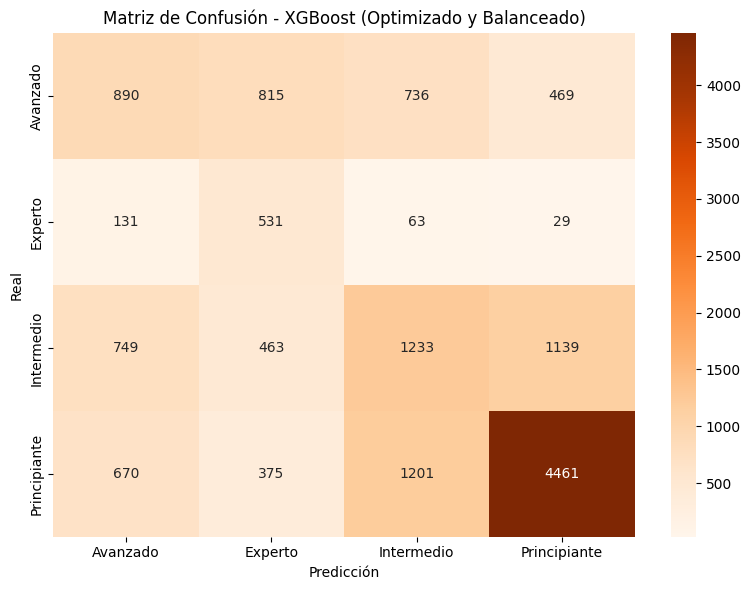


Importancia de características (XGBoost):
                                                 Feature  Importance
77                                   time_control_180+0    0.012002
0                                             time_base    0.011361
25                                   estimated_accuracy    0.004543
283                                     opening_eco_A48    0.004085
47                                   time_control_120+1    0.003709
1346                  opening_name_King's Indian Attack    0.003487
184                                  time_control_600+0    0.003461
346                                     opening_eco_B31    0.003456
489                                     opening_eco_C88    0.003334
953   opening_name_English Opening: King's English V...    0.003272


In [13]:
# --- XGBoost con GridSearchCV y balanceo de clases mediante sample_weight ---
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("\n--- Entrenando y evaluando XGBoost con búsqueda de hiperparámetros y balanceo de clases ---")

# --- Preparación de datos ---
X_xgb = df_model.drop(['elo', 'elo_class'], axis=1, errors='ignore')
y_xgb = df_model['elo_class']
X_xgb = pd.get_dummies(X_xgb, columns=cat_features)

le_xgb = LabelEncoder()
y_xgb_encoded = le_xgb.fit_transform(y_xgb)

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb_encoded, test_size=0.2, random_state=42, stratify=y_xgb_encoded
)

# --- Calcular pesos de clase ---
num_classes = len(np.unique(y_train_xgb))
class_counts = np.bincount(y_train_xgb)
total_samples = len(y_train_xgb)

class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}
print("Pesos de clase:", class_weights)

# Asignar peso a cada muestra del conjunto de entrenamiento
sample_weights = np.array([class_weights[y] for y in y_train_xgb])

# --- Definir modelo base ---
xgb_base = XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42, verbosity=0)

# --- Búsqueda de hiperparámetros ---
param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
    'reg_alpha': [0],
    'reg_lambda': [1, 10]
}

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Entrenar con pesos de clase
grid_search.fit(X_train_xgb, y_train_xgb, sample_weight=sample_weights)

# --- Evaluación final ---
print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)

best_xgb = grid_search.best_estimator_

# Predicciones
y_pred_xgb = best_xgb.predict(X_test_xgb)
y_pred_labels_xgb = le_xgb.inverse_transform(y_pred_xgb)
y_test_labels_xgb = le_xgb.inverse_transform(y_test_xgb)

accuracy_xgb = accuracy_score(y_test_labels_xgb, y_pred_labels_xgb)
print(f"\nXGBoost Accuracy (con hiperparámetros optimizados y balanceo de clases): {accuracy_xgb:.4f}")
print("\nReporte de clasificación (XGBoost):\n", classification_report(y_test_labels_xgb, y_pred_labels_xgb))

# --- Matriz de confusión ---
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_labels_xgb, y_pred_labels_xgb, labels=le_xgb.classes_), annot=True, fmt='d', cmap='Oranges',
            xticklabels=le_xgb.classes_, yticklabels=le_xgb.classes_)
plt.title('Matriz de Confusión - XGBoost (Optimizado y Balanceado)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# --- Importancia de características ---
feature_importances_xgb = best_xgb.feature_importances_
importance_df_xgb = pd.DataFrame({'Feature': X_xgb.columns, 'Importance': feature_importances_xgb})
print("\nImportancia de características (XGBoost):\n", importance_df_xgb.sort_values('Importance', ascending=False).head(10))


In [ ]:
# --- Entrenamiento y evaluación de CatBoost con mejoras ---
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("\n--- Entrenando y evaluando CatBoost ---")

# Preparación de datos
X_cat = df_model.drop(['elo', 'elo_class'], axis=1, errors='ignore')
y_cat = df_model['elo_class']
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_cat, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

# --- Opcional: cálculo de pesos por clase para desbalanceo ---
# from collections import Counter
# class_counts = Counter(y_train_cat)
# total = sum(class_counts.values())
# class_weights = {i: total / count for i, count in class_counts.items()}

# Definición del modelo base
model_catboost = CatBoostClassifier(
    loss_function='MultiClass',
    random_seed=42,
    cat_features=cat_features,
    verbose=0  # silencia el output durante la búsqueda
)

# --- Búsqueda de hiperparámetros con GridSearchCV ---
param_grid = {
    'iterations': [300, 500],
    'learning_rate': [0.03, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=model_catboost,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_cat, y_train_cat)

print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Entrenar el mejor modelo final
best_catboost = grid_search.best_estimator_

# Reentrenar en todo el conjunto de entrenamiento (con early stopping)
best_catboost.fit(
    X_train_cat, y_train_cat,
    eval_set=(X_test_cat, y_test_cat),
    early_stopping_rounds=50,
    verbose=100
)

# --- Evaluación ---
y_pred_catboost = best_catboost.predict(X_test_cat)
accuracy_catboost = accuracy_score(y_test_cat, y_pred_catboost)
print(f"\nCatBoost Accuracy: {accuracy_catboost:.4f}")
print("\nReporte de clasificación (CatBoost):\n", classification_report(y_test_cat, y_pred_catboost))

# --- Matriz de confusión ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix(y_test_cat, y_pred_catboost, labels=best_catboost.classes_),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=best_catboost.classes_, yticklabels=best_catboost.classes_
)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - CatBoost')
plt.show()

# --- Importancia de características ---
feature_importances_catboost = best_catboost.get_feature_importance()
importance_df_catboost = pd.DataFrame({
    'Feature': X_cat.columns,
    'Importance': feature_importances_catboost
}).sort_values('Importance', ascending=False)

print("\nImportancia de características (CatBoost):\n", importance_df_catboost.head(10))

# --- Gráfica del proceso de aprendizaje (loss) ---
eval_results = best_catboost.evals_result_
plt.figure(figsize=(10, 6))
plt.plot(eval_results['validation']['MultiClass'], label='Validación')
plt.plot(eval_results['learn']['MultiClass'], label='Entrenamiento')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida (Loss)')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.legend()
plt.show()



--- Entrenando y evaluando CatBoost ---
Fitting 3 folds for each of 54 candidates, totalling 162 fits


KeyboardInterrupt: 


--- Entrenando y evaluando CatBoost ---
0:	learn: 1.3584233	test: 1.3588075	best: 1.3588075 (0)	total: 283ms	remaining: 2m 20s
100:	learn: 0.9658405	test: 0.9564699	best: 0.9564699 (100)	total: 14.2s	remaining: 56.1s
200:	learn: 0.9305248	test: 0.9161783	best: 0.9161783 (200)	total: 33.3s	remaining: 49.5s
300:	learn: 0.9103885	test: 0.9019223	best: 0.9019223 (300)	total: 52.8s	remaining: 34.9s
400:	learn: 0.8958485	test: 0.8912388	best: 0.8912388 (400)	total: 1m 12s	remaining: 17.8s
499:	learn: 0.8846104	test: 0.8858471	best: 0.8858471 (499)	total: 1m 30s	remaining: 0us

bestTest = 0.8858470613
bestIteration = 499


CatBoost Accuracy: 0.6193

Reporte de clasificación (CatBoost):
               precision    recall  f1-score   support

    Avanzado       0.52      0.51      0.52      2910
     Experto       0.66      0.30      0.41       754
  Intermedio       0.54      0.27      0.36      3584
Principiante       0.67      0.89      0.76      6707

    accuracy                          

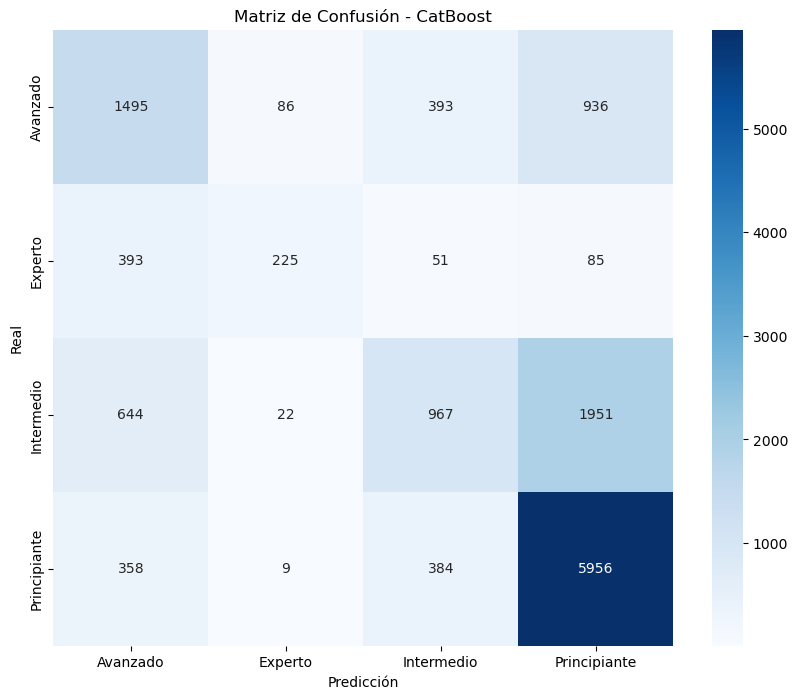


Importancia de características (CatBoost):
                Feature  Importance
26        time_control   18.656331
28        opening_name   15.792478
24         total_moves    9.902832
27         opening_eco    7.813537
25  estimated_accuracy    7.606172
21   avg_time_per_move    5.927433
22            time_std    4.736858
29              result    3.744515
16   midgame_eval_mean    3.126415
15   opening_eval_mean    2.988913


In [13]:
# --- MODELADO (CatBoost, XGBoost, Random Forest, Red Neuronal) ---

# --- CatBoost ---
print("\n--- Entrenando y evaluando CatBoost ---")
X_cat = df_model.drop(['elo', 'elo_class'], axis=1, errors='ignore')
y_cat = df_model['elo_class']
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

model_catboost = CatBoostClassifier(
    iterations=500, learning_rate=0.05, depth=6, loss_function='MultiClass',
    random_seed=42, verbose=100, early_stopping_rounds=50
)
model_catboost.fit(X_train_cat, y_train_cat, cat_features=cat_features, eval_set=(X_test_cat, y_test_cat))

y_pred_catboost = model_catboost.predict(X_test_cat)
accuracy_catboost = accuracy_score(y_test_cat, y_pred_catboost)
print(f"\nCatBoost Accuracy: {accuracy_catboost:.4f}")
print("\nReporte de clasificación (CatBoost):\n", classification_report(y_test_cat, y_pred_catboost))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test_cat, y_pred_catboost, labels=model_catboost.classes_), annot=True, fmt='d', cmap='Blues',
            xticklabels=model_catboost.classes_, yticklabels=model_catboost.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - CatBoost')
plt.show()

feature_importances_catboost = model_catboost.get_feature_importance()
importance_df_catboost = pd.DataFrame({'Feature': X_cat.columns, 'Importance': feature_importances_catboost})
print("\nImportancia de características (CatBoost):\n", importance_df_catboost.sort_values('Importance', ascending=False).head(10))

In [ ]:
# --- XGBoost con GridSearchCV para ajuste de hiperparámetros ---
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

print("\n--- Entrenando y evaluando XGBoost con búsqueda de hiperparámetros ---")

# Datos y codificación como en tu código original
X_xgb = df_model.drop(['elo', 'elo_class'], axis=1, errors='ignore')
y_xgb = df_model['elo_class']
X_xgb = pd.get_dummies(X_xgb, columns=cat_features)
le_xgb = LabelEncoder()
y_xgb_encoded = le_xgb.fit_transform(y_xgb)

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb_encoded, test_size=0.2, random_state=42, stratify=y_xgb_encoded
)

# Definimos el modelo base
xgb_base = XGBClassifier(objective='multi:softmax', num_class=len(le_xgb.classes_), random_state=42, verbosity=0)

# Definimos la búsqueda de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 10]
}

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1  # Usa todos los núcleos disponibles
)

# Ejecutar la búsqueda
grid_search.fit(X_train_xgb, y_train_xgb)

# Mostrar mejores parámetros
print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Usar el mejor modelo encontrado
best_xgb = grid_search.best_estimator_

# Evaluar en el conjunto de prueba
y_pred_xgb = best_xgb.predict(X_test_xgb)
y_pred_labels_xgb = le_xgb.inverse_transform(y_pred_xgb)
y_test_labels_xgb = le_xgb.inverse_transform(y_test_xgb)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy_xgb = accuracy_score(y_test_labels_xgb, y_pred_labels_xgb)
print(f"\nXGBoost Accuracy (con hiperparámetros optimizados): {accuracy_xgb:.4f}")
print("\nReporte de clasificación (XGBoost):\n", classification_report(y_test_labels_xgb, y_pred_labels_xgb))

# Matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_labels_xgb, y_pred_labels_xgb, labels=le_xgb.classes_), annot=True, fmt='d', cmap='Oranges',
            xticklabels=le_xgb.classes_, yticklabels=le_xgb.classes_)
plt.title('Matriz de Confusión - XGBoost (Optimizado)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# Importancia de características
feature_importances_xgb = best_xgb.feature_importances_
importance_df_xgb = pd.DataFrame({'Feature': X_xgb.columns, 'Importance': feature_importances_xgb})
print("\nImportancia de características (XGBoost):\n", importance_df_xgb.sort_values('Importance', ascending=False).head(10))



--- Entrenando y evaluando XGBoost ---

XGBoost Accuracy: 0.5681

Reporte de clasificación (XGBoost):
               precision    recall  f1-score   support

    Avanzado       0.44      0.42      0.43      2910
     Experto       0.54      0.21      0.31       754
  Intermedio       0.42      0.19      0.26      3584
Principiante       0.64      0.87      0.74      6707

    accuracy                           0.57     13955
   macro avg       0.51      0.43      0.43     13955
weighted avg       0.53      0.57      0.53     13955



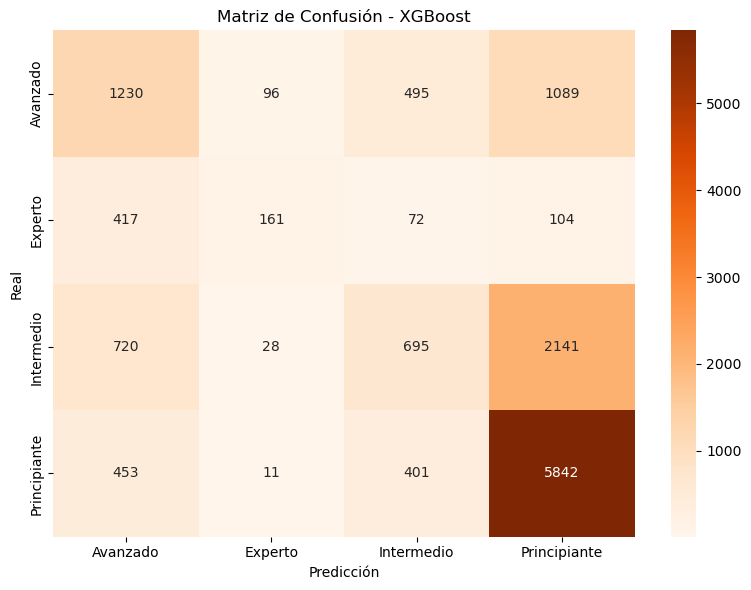


Importancia de características (XGBoost):
                                                 Feature  Importance
77                                   time_control_180+0    0.010936
0                                             time_base    0.009046
427                                     opening_eco_C20    0.006546
25                                   estimated_accuracy    0.006545
447                                     opening_eco_C40    0.005411
454                                     opening_eco_C47    0.004850
499                                     opening_eco_D00    0.004777
47                                   time_control_120+1    0.004510
1572                      opening_name_Philidor Defense    0.004344
1771  opening_name_Queen's Pawn Game: Chigorin Varia...    0.004092


In [18]:
# --- XGBoost ---
print("\n--- Entrenando y evaluando XGBoost ---")
X_xgb = df_model.drop(['elo', 'elo_class'], axis=1, errors='ignore')
y_xgb = df_model['elo_class']
X_xgb = pd.get_dummies(X_xgb, columns=cat_features)
le_xgb = LabelEncoder()
y_xgb_encoded = le_xgb.fit_transform(y_xgb)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb_encoded, test_size=0.2, random_state=42, stratify=y_xgb_encoded
)

model_xgb = XGBClassifier(objective='multi:softmax', num_class=len(le_xgb.classes_), random_state=42, verbosity=0)
model_xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = model_xgb.predict(X_test_xgb)
y_pred_labels_xgb = le_xgb.inverse_transform(y_pred_xgb)
y_test_labels_xgb = le_xgb.inverse_transform(y_test_xgb)

accuracy_xgb = accuracy_score(y_test_labels_xgb, y_pred_labels_xgb)
print(f"\nXGBoost Accuracy: {accuracy_xgb:.4f}")
print("\nReporte de clasificación (XGBoost):\n", classification_report(y_test_labels_xgb, y_pred_labels_xgb))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_labels_xgb, y_pred_labels_xgb, labels=le_xgb.classes_), annot=True, fmt='d', cmap='Oranges',
            xticklabels=le_xgb.classes_, yticklabels=le_xgb.classes_)
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

feature_importances_xgb = model_xgb.feature_importances_
importance_df_xgb = pd.DataFrame({'Feature': X_xgb.columns, 'Importance': feature_importances_xgb})
print("\nImportancia de características (XGBoost):\n", importance_df_xgb.sort_values('Importance', ascending=False).head(10))

In [19]:
from sklearn.ensemble import RandomForestClassifier


--- Entrenando y evaluando Random Forest ---
Random Forest Accuracy: 0.4815


c:\Users\marti\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marti\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marti\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Reporte de clasificación (Random Forest):
               precision    recall  f1-score   support

    Avanzado       0.30      0.00      0.01      2910
     Experto       0.00      0.00      0.00       754
  Intermedio       0.00      0.00      0.00      3584
Principiante       0.48      1.00      0.65      6707

    accuracy                           0.48     13955
   macro avg       0.20      0.25      0.16     13955
weighted avg       0.30      0.48      0.31     13955



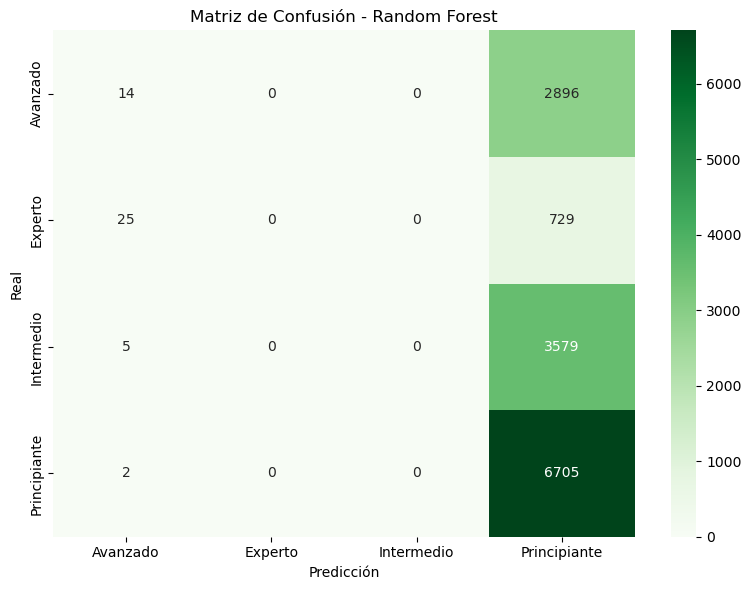


Importancia de características (Random Forest):
                Feature  Importance
25  estimated_accuracy    0.097149
8         blunder_rate    0.079140
77  time_control_180+0    0.059720
21   avg_time_per_move    0.054930
0            time_base    0.052305
24         total_moves    0.049422
16   midgame_eval_mean    0.036685
9         mistake_rate    0.035775
3             eval_std    0.035387
1       time_increment    0.028425


In [20]:
# --- Random Forest ---
print("\n--- Entrenando y evaluando Random Forest ---")
X_rf = pd.get_dummies(df_model.drop(['elo', 'elo_class'], axis=1, errors='ignore'), columns=cat_features)
y_rf = df_model['elo_class']
le_rf = LabelEncoder()
y_rf_encoded = le_rf.fit_transform(y_rf)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf_encoded, test_size=0.2, random_state=42, stratify=y_rf_encoded
)

model_rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, max_depth=10)
model_rf.fit(X_train_rf, y_train_rf)
y_pred_rf = model_rf.predict(X_test_rf)
y_pred_labels_rf = le_rf.inverse_transform(y_pred_rf)
y_test_labels_rf = le_rf.inverse_transform(y_test_rf)

accuracy_rf = accuracy_score(y_test_labels_rf, y_pred_labels_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("\nReporte de clasificación (Random Forest):\n", classification_report(y_test_labels_rf, y_pred_labels_rf))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_labels_rf, y_pred_labels_rf, labels=le_rf.classes_), annot=True, fmt='d', cmap='Greens',
            xticklabels=le_rf.classes_, yticklabels=le_rf.classes_)
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

importance_rf = model_rf.feature_importances_
importance_df_rf = pd.DataFrame({'Feature': X_train_rf.columns, 'Importance': importance_rf})
print("\nImportancia de características (Random Forest):\n", importance_df_rf.sort_values('Importance', ascending=False).head(10))


In [23]:
from sklearn.preprocessing import StandardScaler

In [21]:
from tensorflow import keras

In [ ]:
# --- Red Neuronal Mejorada ---
print("\n--- Entrenando y evaluando Red Neuronal Mejorada ---")

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Copia del dataframe original para no modificar df_model directamente
df = df_model.copy()

# Definimos las variables categóricas 
cat_features = ['opening_eco', 'time_control']  
num_features = [col for col in df.columns if col not in cat_features + ['elo', 'elo_class']]

# Codificar variables categóricas como enteros (para embeddings)
ordinal_enc = OrdinalEncoder()
df[cat_features] = ordinal_enc.fit_transform(df[cat_features])

# Separar variables y etiquetas
X = df.drop(['elo', 'elo_class'], axis=1)
y = df['elo_class']

# Codificar etiquetas de clase como enteros
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

# División de datos con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Escalar características numéricas
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_features])
X_test_num = scaler.transform(X_test[num_features])

# Extraer arrays de variables categóricas para Keras
X_train_cat = X_train[cat_features].values
X_test_cat = X_test[cat_features].values

# Convertir etiquetas a codificación one-hot
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes=num_classes)

# --- Definición del modelo ---
# Entradas numéricas
input_num = keras.Input(shape=(X_train_num.shape[1],), name='numericas')

# Entradas categóricas (una entrada por variable categórica)
input_cat = [keras.Input(shape=(1,), name=f'{col}') for col in cat_features]

# Embedding layers para las variables categóricas
embedding_layers = []
for i, col in enumerate(cat_features):
    vocab_size = int(df[col].nunique()) + 1  # +1 por seguridad
    embed_dim = min(50, vocab_size // 2)  # Heurística común: min(50, cardinalidad/2)
    emb = keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, name=f'emb_{col}')(input_cat[i])
    emb = keras.layers.Flatten()(emb)  # Convertir el embedding 2D a 1D
    embedding_layers.append(emb)

# Concatenar todas las entradas
x = keras.layers.Concatenate()([input_num] + embedding_layers)

# Capas ocultas densas con BatchNormalization y Dropout
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

# Capa de salida para clasificación multiclase
output = keras.layers.Dense(num_classes, activation='softmax')(x)

# Definición final del modelo
model = keras.Model(inputs=[input_num] + input_cat, outputs=output)

# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Entrenamiento con EarlyStopping ---
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

history = model.fit(
    [X_train_num] + [X_train_cat[:, i] for i in range(X_train_cat.shape[1])],
    y_train_one_hot,
    validation_split=0.1,  # Reservamos el 10% para validación
    epochs=50,            # Permitimos hasta 50 épocas
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Evaluación en el conjunto de prueba ---
loss, accuracy = model.evaluate(
    [X_test_num] + [X_test_cat[:, i] for i in range(X_test_cat.shape[1])],
    y_test_one_hot,
    verbose=0
)
print(f"Accuracy Red Neuronal Mejorada: {accuracy:.4f}")

# --- Predicciones ---
y_pred_proba = model.predict([X_test_num] + [X_test_cat[:, i] for i in range(X_test_cat.shape[1])])
y_pred = np.argmax(y_pred_proba, axis=1)
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(np.argmax(y_test_one_hot, axis=1))

print("\nReporte de clasificación (Red Neuronal Mejorada):\n", classification_report(y_test_labels, y_pred_labels))

# --- Matriz de confusión ---
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_), annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión - Red Neuronal Mejorada')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# --- Gráficas de evolución del entrenamiento ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss entrenamiento')
plt.plot(history.history['val_loss'], label='Loss validación')
plt.title('Evolución de la pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy validación')
plt.title('Evolución de la precisión')
plt.legend()

plt.tight_layout()
plt.show()



--- Entrenando y evaluando Red Neuronal ---


c:\Users\marti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Red Neuronal Accuracy: 0.5698
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Reporte de clasificación (Red Neuronal):
               precision    recall  f1-score   support

    Avanzado       0.45      0.41      0.43      2910
     Experto       0.61      0.11      0.19       754
  Intermedio       0.43      0.28      0.34      3584
Principiante       0.64      0.85      0.73      6707

    accuracy                           0.57     13955
   macro avg       0.53      0.41      0.42     13955
weighted avg       0.55      0.57      0.54     13955



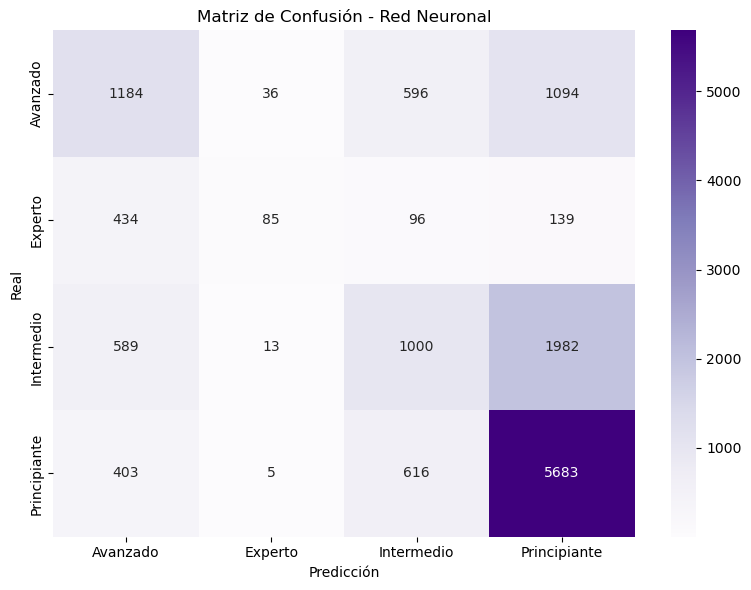

In [24]:
# --- Red Neuronal ---
print("\n--- Entrenando y evaluando Red Neuronal ---")
X_nn = pd.get_dummies(df_model.drop(['elo', 'elo_class'], axis=1, errors='ignore'), columns=cat_features)
y_nn = df_model['elo_class']
le_nn = LabelEncoder()
y_nn_encoded = le_nn.fit_transform(y_nn)
num_classes = len(le_nn.classes_)

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn, y_nn_encoded, test_size=0.2, random_state=42, stratify=y_nn_encoded
)

# Escalar características numéricas para la red neuronal
scaler = StandardScaler()
X_train_scaled_nn = scaler.fit_transform(X_train_nn)
X_test_scaled_nn = scaler.transform(X_test_nn)

# Convertir etiquetas a codificación one-hot
y_train_one_hot_nn = keras.utils.to_categorical(y_train_nn, num_classes=num_classes)
y_test_one_hot_nn = keras.utils.to_categorical(y_test_nn, num_classes=num_classes)

model_nn = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled_nn.shape[1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(num_classes, activation='softmax')
])

model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_nn = model_nn.fit(X_train_scaled_nn, y_train_one_hot_nn, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

loss_nn, accuracy_nn = model_nn.evaluate(X_test_scaled_nn, y_test_one_hot_nn, verbose=0)
print(f"Red Neuronal Accuracy: {accuracy_nn:.4f}")

y_pred_proba_nn = model_nn.predict(X_test_scaled_nn)
y_pred_nn = np.argmax(y_pred_proba_nn, axis=1)
y_pred_labels_nn = le_nn.inverse_transform(y_pred_nn)
y_test_labels_nn = le_nn.inverse_transform(np.argmax(y_test_one_hot_nn, axis=1))

print("\nReporte de clasificación (Red Neuronal):\n", classification_report(y_test_labels_nn, y_pred_labels_nn))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_labels_nn, y_pred_labels_nn, labels=le_nn.classes_), annot=True, fmt='d', cmap='Purples',
            xticklabels=le_nn.classes_, yticklabels=le_nn.classes_)
plt.title('Matriz de Confusión - Red Neuronal')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()



--- Modelo con variables de puntuación y precisión ---
0:	learn: 1.3631329	test: 1.3633809	best: 1.3633809 (0)	total: 34.7ms	remaining: 17.3s
100:	learn: 1.1337933	test: 1.1373096	best: 1.1373096 (100)	total: 979ms	remaining: 3.87s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.137184276
bestIteration = 136

Shrink model to first 137 iterations.

Accuracy (Puntuación y Precisión): 0.4823


c:\Users\marti\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marti\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marti\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Reporte de clasificación (Puntuación y Precisión):
               precision    recall  f1-score   support

    Avanzado       0.31      0.15      0.20      2910
     Experto       0.00      0.00      0.00       754
  Intermedio       0.00      0.00      0.00      3584
Principiante       0.50      0.94      0.65      6707

    accuracy                           0.48     13955
   macro avg       0.20      0.27      0.21     13955
weighted avg       0.31      0.48      0.36     13955



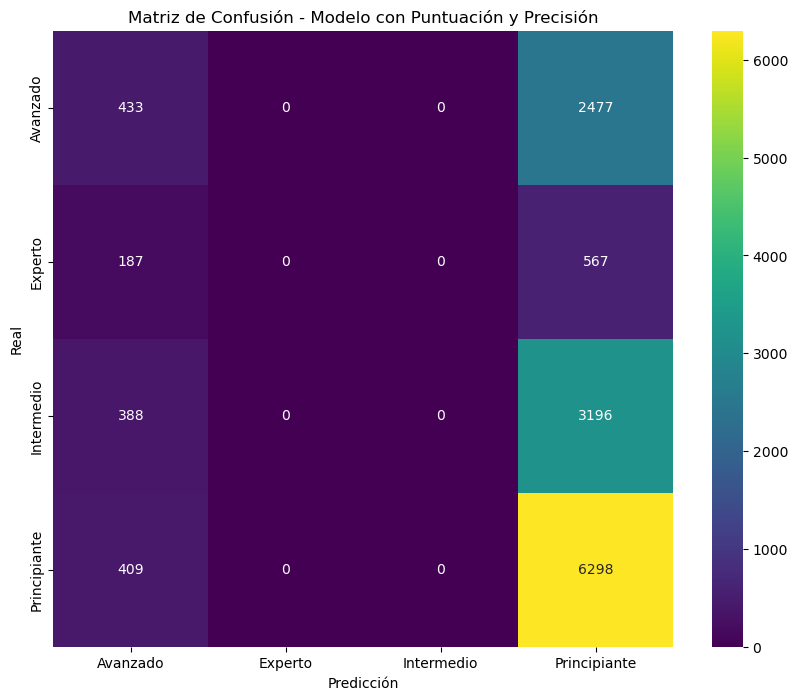


Importancia de características (Puntuación y Precisión):
                  Feature  Importance
5     estimated_accuracy       100.0
0    brilliant_moves_ann         0.0
1      blunder_moves_ann         0.0
2  interesting_moves_ann         0.0
3      mistake_moves_ann         0.0
4    excellent_moves_ann         0.0


In [25]:
# --- Modelo con variables de puntuación y precisión ---
print("\n--- Modelo con variables de puntuación y precisión ---")
features_puntuacion = [
    'brilliant_moves_ann',
    'blunder_moves_ann',
    'interesting_moves_ann',
    'mistake_moves_ann',
    'excellent_moves_ann',
    'estimated_accuracy'
]

# Asegurarse de que estas columnas existan en el DataFrame df_model
for feature in features_puntuacion:
    if feature not in df_model.columns:
        raise ValueError(f"La columna '{feature}' no se encuentra en el DataFrame df_model. Por favor, revisa las características extraídas.")

X_puntuacion = df_model[features_puntuacion]
y_puntuacion = df_model['elo_class']

X_train_puntuacion, X_test_puntuacion, y_train_puntuacion, y_test_puntuacion = train_test_split(
    X_puntuacion, y_puntuacion, test_size=0.2, random_state=42, stratify=y_puntuacion
)

model_puntuacion = CatBoostClassifier(
    iterations=500, learning_rate=0.05, depth=6, loss_function='MultiClass',
    random_seed=42, verbose=100, early_stopping_rounds=50
)
model_puntuacion.fit(X_train_puntuacion, y_train_puntuacion, eval_set=(X_test_puntuacion, y_test_puntuacion), verbose=100)

y_pred_puntuacion = model_puntuacion.predict(X_test_puntuacion)
accuracy_puntuacion = accuracy_score(y_test_puntuacion, y_pred_puntuacion)
print(f"\nAccuracy (Puntuación y Precisión): {accuracy_puntuacion:.4f}")
print("\nReporte de clasificación (Puntuación y Precisión):\n", classification_report(y_test_puntuacion, y_pred_puntuacion))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test_puntuacion, y_pred_puntuacion, labels=model_puntuacion.classes_), annot=True, fmt='d', cmap='viridis',
            xticklabels=model_puntuacion.classes_, yticklabels=model_puntuacion.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Modelo con Puntuación y Precisión')
plt.show()

importance_puntuacion = model_puntuacion.get_feature_importance()
importance_df_puntuacion = pd.DataFrame({'Feature': X_puntuacion.columns, 'Importance': importance_puntuacion})
print("\nImportancia de características (Puntuación y Precisión):\n", importance_df_puntuacion.sort_values('Importance', ascending=False))